# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

In [1]:
from hera_sim.visibilities import VisCPU, HealVis
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import pyuvsim
from pyuvsim.analyticbeam import AnalyticBeam
from astropy.units import sday
import matplotlib as mpl

from healvis.sky_model import gsm_shell
from healvis.utils import jy2Tsr

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams["legend.loc"] = 'upper left'

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/jackson/hera/hera_sim/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


First, we will load a few scripts that will be useful later for displaying how the visibilities evolve over time. 

In [2]:
# Displays the real and imaginary components of all autocorrelations on plot one
# and real and imaginary components of all cross-correlations on a plot two.
def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16,8))
    fig.suptitle(type(simulator).__name__, fontweight='bold')
    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))
        auto_cor = simulator.uvdata.data_array[auto_ind, 0, 0, 0]
        ax[0].plot(auto_cor.real, label="ant_{} real".format(i))
        ax[0].plot(auto_cor.imag, linestyle="--", label="ant_{} imag".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j))
            cross_cor = simulator.uvdata.data_array[cross_ind, 0, 0, 0]
            ax[1].plot(cross_cor.real, label="bl({},{}) real".format(i,j))
            ax[1].plot(cross_cor.imag, linestyle="--", label="bl({},{}) imag".format(i,j))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("Observation Number")

# Displays the real components of all autocorrelations of two simulators on
# plot one, the real compoents of all cross-correlations on plot two, and
# the difference between the real components of cross-correlations on plot
# three (simulator2 - simulator1).
def compare_blts(simulator1, simulator2):
    fig, ax = plt.subplots(3, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16, 12)) 
    name1 = type(simulator1).__name__
    name2 = type(simulator2).__name__
    fig.suptitle(name1 + " vs " + name2, fontweight='bold')
    k = 0
    for i in simulator1.uvdata.antenna_numbers:
        auto_ind = simulator1.uvdata.antpair2ind((i,i))
        auto1 = np.real(simulator1.uvdata.data_array[auto_ind, 0, 0, 0])
        auto2 = np.real(simulator2.uvdata.data_array[auto_ind, 0, 0, 0])               
        ax[0].plot(auto1, label=("ant_{} " + name1).format(i))
        ax[0].plot(auto2, linestyle="--", label=("ant_{} " + name2).format(i))
        for j in simulator1.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator1.uvdata.antpair2ind((i,j))
            cross1 = np.real(simulator1.uvdata.data_array[cross_ind, 0, 0, 0])
            cross2 = np.real(simulator2.uvdata.data_array[cross_ind, 0, 0, 0])       
            ax[1].plot(cross1, label=("bl({},{}) " + name1).format(i,j))
            ax[1].plot(cross2, linestyle="--", label=("bl({},{}) " + name2).format(i,j))
            ax[2].plot(cross2 - cross1, label=("bl({},{}) " + "Difference").format(i,j), color=str(k/(k+1)))
            k += 1
    [a.legend() for a in ax]
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[2].set_title(name2 + " Cross-Correlation minus " + name1 + " Cross-Correlation")
    ax[-1].set_xlabel("Observation Number")

The `VisibilitySimulator` class uses `HEALPix` maps to represent diffuse emission:

In [3]:
def uniform_sky(nbase=4, scale=1, nfreq=5):
    """Create a uniform sky with total (integrated) flux density of `scale`."""
    nside = 2 ** nbase
    npix = 12 * nside ** 2
    return np.ones((nfreq, npix)) * scale / (4 * np.pi)

def half_uniform_sky(nbase=4, scale=1, nfreq=5):
    """Create a sky where half is uniform with total (integrated) flux density 
    of `scale` and half has zero flux.
    """
    I_sky = uniform_sky(nbase=nbase, scale=2*scale, nfreq=nfreq)
    npix = I_sky[0].shape[0]
    vec = healpy.ang2vec(np.pi/2, 0)
    # Zero out values within pi/2 of (theta=pi/2, phi=0)
    ipix_disc = healpy.query_disc(nside=2**nbase, vec=vec, radius=np.pi/2)
    for i in range(nfreq):
        I_sky[i][ipix_disc] = 0
    return I_sky

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [4]:
def myuvdata(ntimes=48, ntel=2, **kwargs):
    
    # Choosing antenna postions in a deterministic way
    ants = {}
    for i in range(ntel):
        ants.update([(i, (-(i % 3), i, i % 4))])
      
    return io.empty_uvdata(
        nfreq=5,
        integration_time=sday.to('s')/ntimes,
        ntimes=ntimes,
        ants=ants,
        **kwargs
    )

## HealVis

In [5]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase
I_sky = uniform_sky()

simulator = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=I_sky
)


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^



Finished: 1, Elapsed 0.03min, Remain 0.026hour, MaxRSS 0.187816GB



Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^



Finished: 2, Elapsed 0.03min, Remain 0.013hour, MaxRSS 0.229636GB
Finished: 3, Elapsed 0.03min, Remain 0.008hour, MaxRSS 0.229636GB
Finished: 4, Elapsed 0.03min, Remain 0.006hour, MaxRSS 0.229636GB
Finished: 5, Elapsed 0.03min, Remain 0.005hour, MaxRSS 0.229636GB
Finished: 6, Elapsed 0.03min, Remain 0.004hour, MaxRSS 0.229636GB
Finished: 7, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.229636GB
Finished: 8, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.229636GB
Finished: 9, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.229636GB
Finished: 10, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.229636GB
Finished: 11, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.229636GB
Finished: 12, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.229636GB
Finished: 13, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.229636GB
Finished: 14, Elapsed 0.04min, Remain 0.001hour, MaxRSS 0.229636GB
Finished: 15, Elapsed 0.04min, Remain 0.001hour, MaxRSS 0.229636GB
Finished: 16, Elapsed 0.04min, Remain 0.001hour, MaxRSS 0.229636GB
Fin

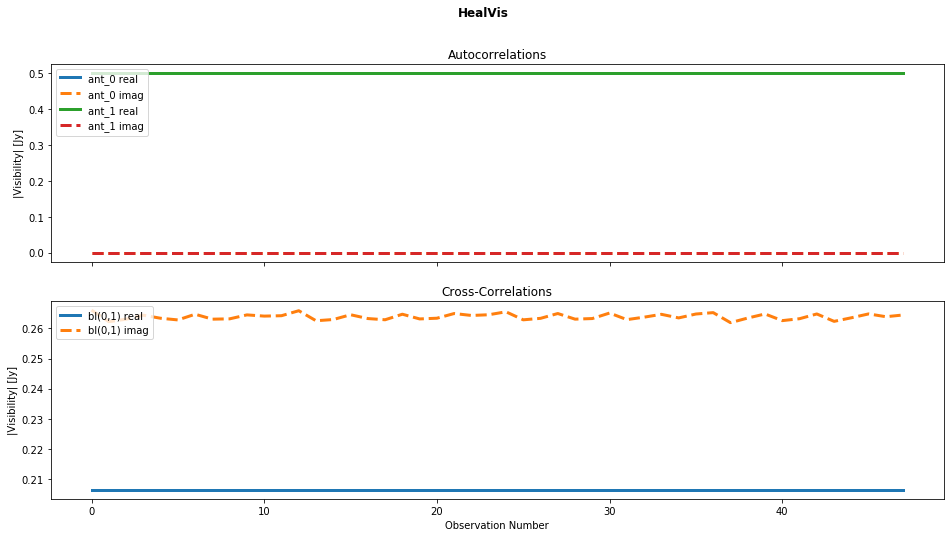

In [6]:
vis = simulator.simulate()
plot_blts(simulator)

`VisibilitySimulators` can also take point sources as inputs. `point_source_pos` is an array of each source position in (ra, dec). `point_source_flux` is an array of each source flux at each frequency in Jy.

In [7]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

simulator = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    nside=nside
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels.



Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.026hour, MaxRSS 0.189564GB
Finished: 2, Elapsed 0.03min, Remain 0.013hour, MaxRSS 0.212032GB
Finished: 3, Elapsed 0.03min, Remain 0.009hour, MaxRSS 0.212036GB
Finished: 4, Elapsed 0.03min, Remain 0.006hour, MaxRSS 0.212036GB
Finished: 5, Elapsed 0.04min, Remain 0.005hour, MaxRSS 0.212036GB
Finished: 6, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.212036GB
Finished: 7, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.212036GB
Finished: 8, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.212036GB
Finished: 9, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.212036GB
Finished: 10, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Finished: 11, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Finished: 12, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Finished: 13, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Finished: 14, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Finished: 15, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212036GB
Fini

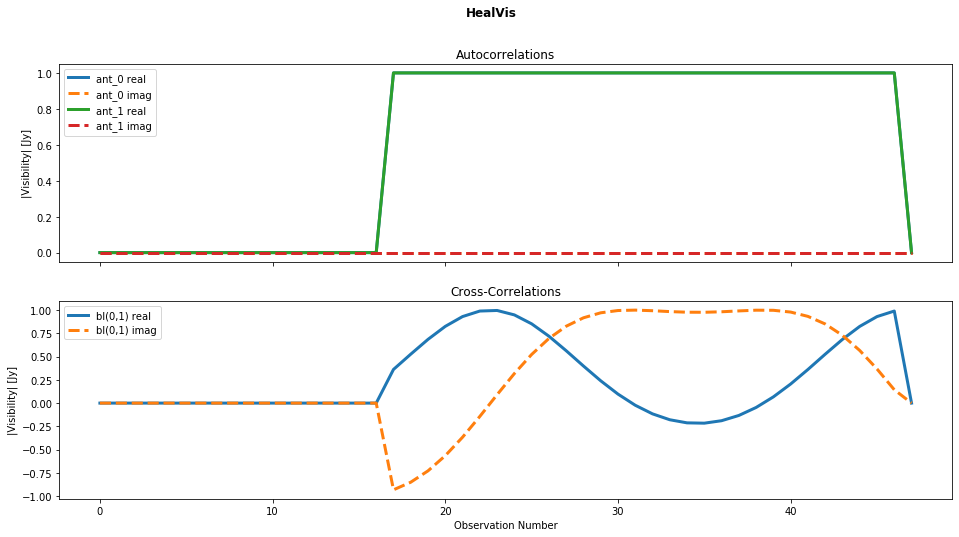

In [8]:
vis = simulator.simulate()
plot_blts(simulator)

## VisCPU

We could have also used `VisCPU` for this:

In [9]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

simulator = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf
)

invalid value encountered in sqrt


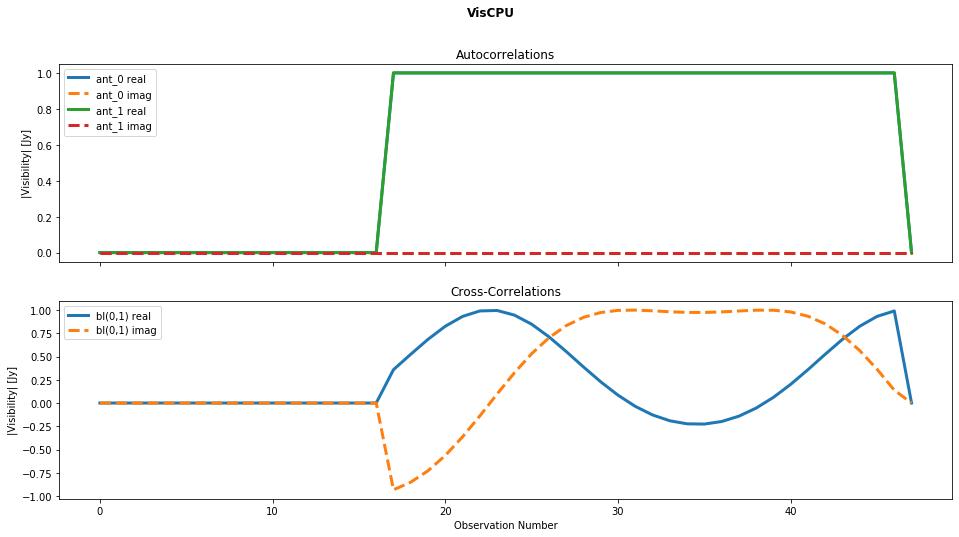

In [10]:
vis = simulator.simulate()
plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. Each beam is of type `pyuvsim.analyticbeam.AnalyticBeam`, one for each antenna. 
If included, an extra list of `beam_ids` specifies which of the beams each antenna uses. Otherwise by default all antennas are assumed to use the zeroth entry in `beams`. So, we can create something like one beam being Gaussian and the other uniform:

In [11]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))
simulator = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("gaussian", sigma=0.5), AnalyticBeam("uniform")],
    beam_ids=[0, 1],
    nside=nside
)

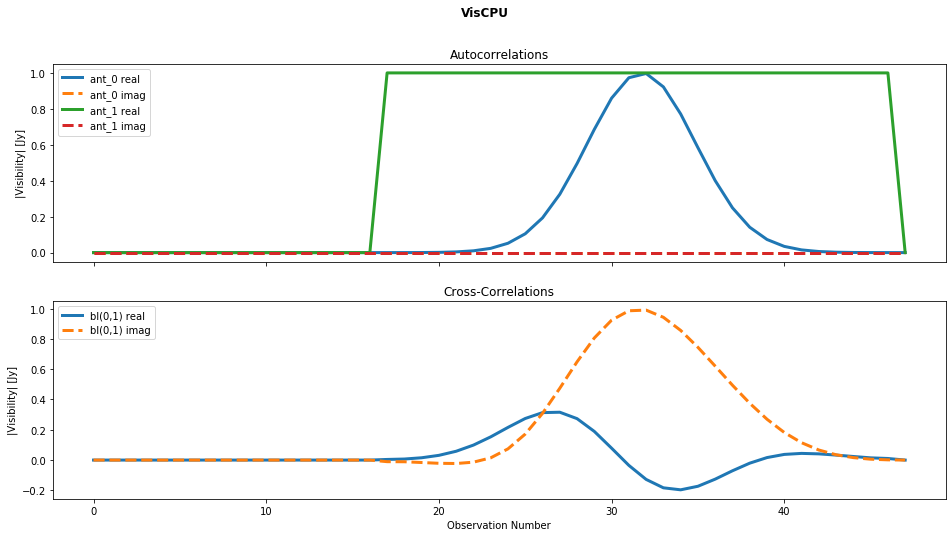

In [12]:
vis = simulator.simulate()
plot_blts(simulator)

## Comparing VisCPU & HealVis

To compare `VisCPU` and `Healvis` most accurately we must take into account how they sources differently. `VisCPU` treats the sky as a collection of point sources while `Healvis` must convert point sources into `HEALPix` maps. Error is introduced if a point source location is not at the center of a `HEALPix` pixel. To account for this we can relocate point sources to their nearest `HEALPix` centers before passing them in as arguments using `align_src_to_healpix`.

In [13]:
def align_src_to_healpix(point_source_pos, point_source_flux, nside=2**4):
    """Where the point sources will be placed when converted to healpix model
    
    Parameters
    ----------
    point_source_pos : ndarray
        Positions of point sources to be passed to a Simulator.
    point_source_flux : ndarray
        Corresponding fluxes of point sources at each frequency.
    nside : int
        Healpy nside parameter.
        

    Returns
    -------
    new_pos: ndarray
        Point sources positioned at their nearest healpix centers.
    new_flux: ndarray
        Corresponding new flux values.       
    """
    
    hmap = np.zeros((len(point_source_flux), healpy.nside2npix(nside)))

    # Get which pixel every point source lies in.
    pix = healpy.ang2pix(nside, np.pi/2 - point_source_pos[:, 1], point_source_pos[:, 0])

    hmap[:, pix] += point_source_flux / healpy.nside2pixarea(nside)
    nside = healpy.get_nside(hmap[0])
    ra, dec = healpy.pix2ang(nside, np.arange(len(hmap[0])), lonlat=True)
    flux = hmap * healpy.nside2pixarea(nside)
    return np.array([ra*np.pi/180, dec*np.pi/180]).T, flux

### Multiple Point Sources

In [14]:
uvdata = myuvdata(ntel=3)
uvdata1 = myuvdata(ntel=3)
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0] + np.pi/4],
                [0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0, 1.0]] * len(freqs))
psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    nside=nside
)


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.026hour, MaxRSS 0.15698GB
Finished: 2, Elapsed 0.03min, Remain 0.013hour, MaxRSS 0.21202GB
Finished: 3, Elapsed 0.04min, Remain 0.009hour, MaxRSS 0.212032GB
Finished: 5, Elapsed 0.04min, Remain 0.005hour, MaxRSS 0.21204GB
Finished: 4, Elapsed 0.04min, Remain 0.007hour, MaxRSS 0.21204GB
Finished: 6, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.21204GB
Finished: 7, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.212044GB
Finished: 8, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.212044GB
Finished: 9, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.212048GB
Finished: 10, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.212048GB
Finished: 11, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212048GB
Finished: 12, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.212048GB
Finished: 13, Elapsed 0.05min, Remain 0.002hour, MaxRSS 0.212048GB
Finished: 14, Elapsed 0.05min, Remain 0.002hour, MaxRSS 0.212048GB
Finished: 15, Elapsed 0.05min, Remain 0.002hour, MaxRSS 0.212048GB
Finished:

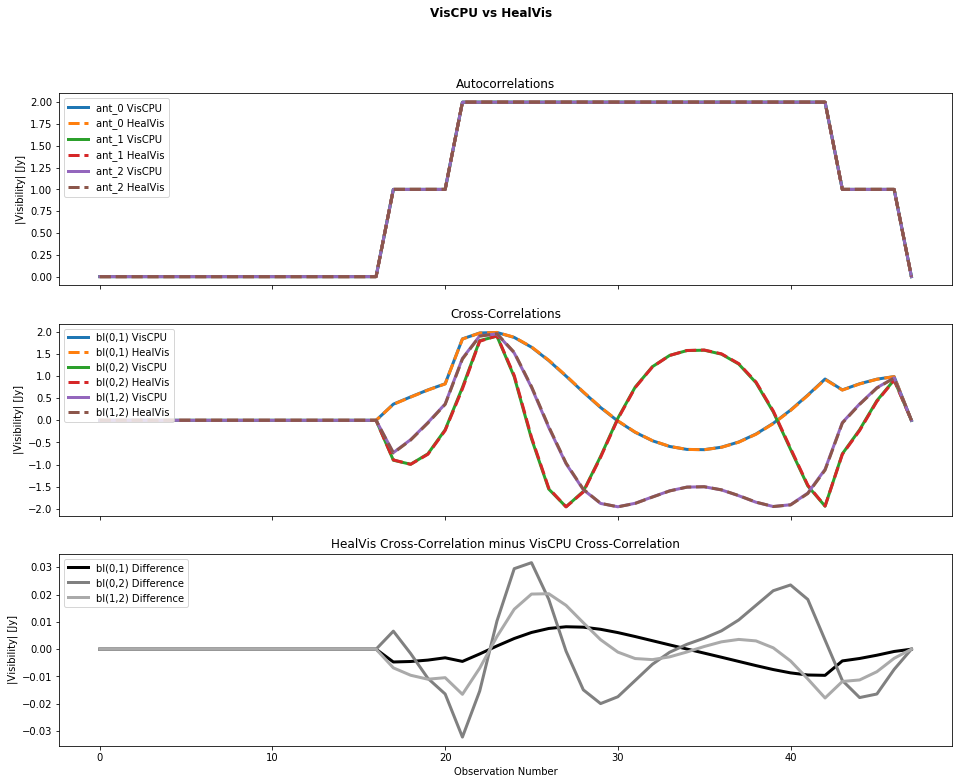

In [15]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### Half Uniform Sky

In [16]:
uvdata = myuvdata(ntel=3)
uvdata1 = myuvdata(ntel=3)
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase
I_sky = half_uniform_sky()

viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_freqs=freqs,
    sky_intensity=I_sky,
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=I_sky,
    nside=nside
)


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.024hour, MaxRSS 0.157116GB
Finished: 2, Elapsed 0.03min, Remain 0.012hour, MaxRSS 0.206536GB
Finished: 3, Elapsed 0.03min, Remain 0.008hour, MaxRSS 0.206536GB
Finished: 4, Elapsed 0.03min, Remain 0.006hour, MaxRSS 0.206536GB
Finished: 5, Elapsed 0.03min, Remain 0.005hour, MaxRSS 0.206536GB
Finished: 6, Elapsed 0.03min, Remain 0.004hour, MaxRSS 0.206536GB
Finished: 7, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.206536GB
Finished: 8, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.206536GB
Finished: 13, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.206536GB
Finished: 9, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.206536GB
Finished: 10, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.206536GB
Finished: 11, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.206536GB
Finished: 12, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.206536GB
Finished: 14, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.206536GB
Finished: 15, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.206536GB
Fini

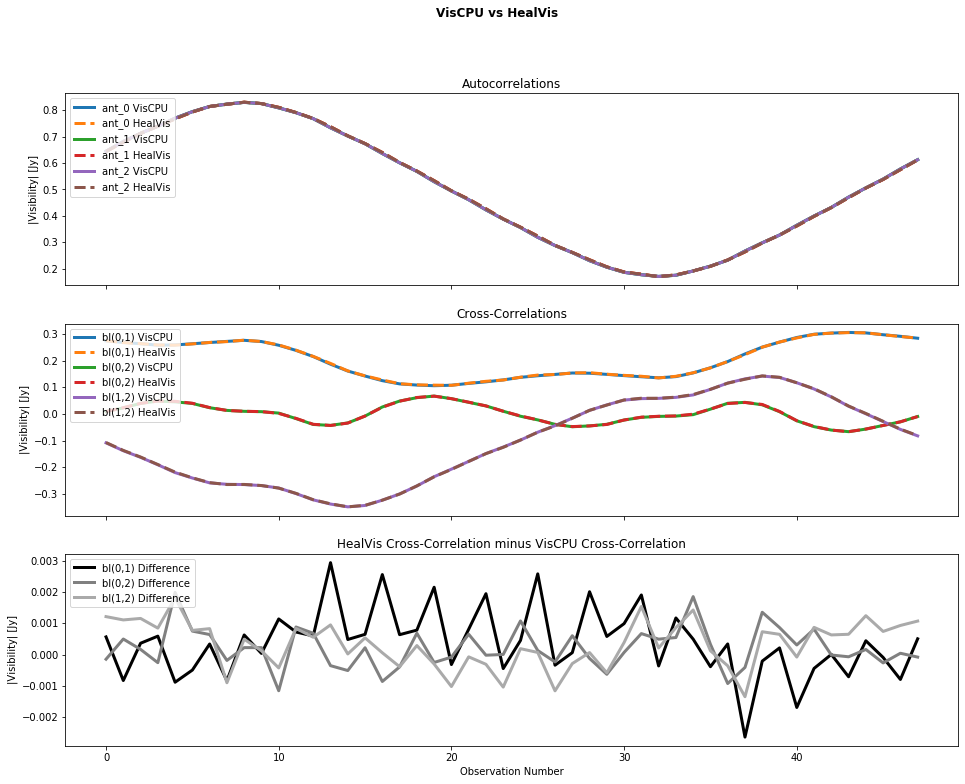

In [17]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### Airy Beams

In [18]:
uvdata = myuvdata(ntel=3)
uvdata1 = myuvdata(ntel=3)
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 4, Elapsed 0.03min, Remain 0.006hour, MaxRSS 0.21076GB
Finished: 1, Elapsed 0.03min, Remain 0.025hour, MaxRSS 0.161632GB
Finished: 2, Elapsed 0.03min, Remain 0.012hour, MaxRSS 0.21076GB
Finished: 3, Elapsed 0.03min, Remain 0.008hour, MaxRSS 0.21076GB
Finished: 5, Elapsed 0.03min, Remain 0.005hour, MaxRSS 0.21076GB
Finished: 6, Elapsed 0.03min, Remain 0.004hour, MaxRSS 0.21076GB
Finished: 7, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.21076GB
Finished: 8, Elapsed 0.03min, Remain 0.003hour, MaxRSS 0.21076GB
Finished: 9, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.21076GB
Finished: 10, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.21076GB
Finished: 11, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.21076GB
Finished: 12, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.21076GB
Finished: 13, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.21076GB
Finished: 14, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.21076GB
Finished: 15, Elapsed 0.04min, Remain 0.001hour, MaxRSS 0.21076GB
Finished: 16, Elap

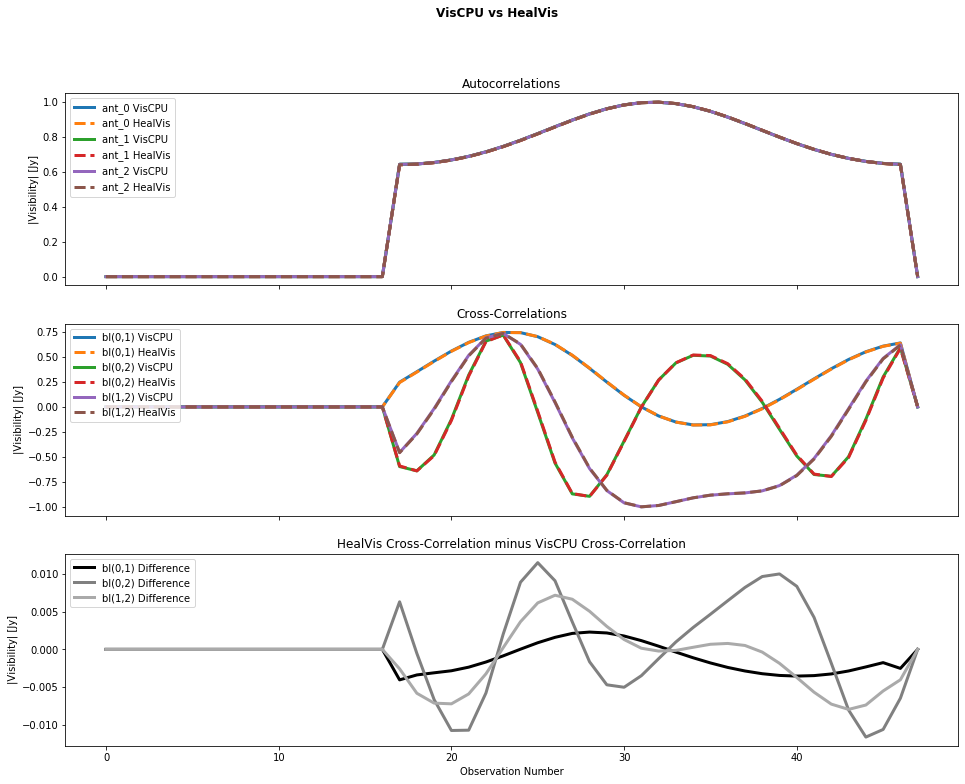

In [19]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### All Together

In [20]:
uvdata = myuvdata(ntel=3)
uvdata1 = myuvdata(ntel=3)
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0] + np.pi/4],
                [0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0, 1.0]] * len(freqs))
psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity = half_uniform_sky(nbase),
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    sky_intensity = half_uniform_sky(nbase),
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.026hour, MaxRSS 0.167832GB
Finished: 2, Elapsed 0.03min, Remain 0.013hour, MaxRSS 0.213516GB
Finished: 3, Elapsed 0.03min, Remain 0.009hour, MaxRSS 0.213528GB
Finished: 4, Elapsed 0.04min, Remain 0.006hour, MaxRSS 0.213528GB
Finished: 5, Elapsed 0.04min, Remain 0.005hour, MaxRSS 0.213528GB
Finished: 6, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.213536GB
Finished: 7, Elapsed 0.04min, Remain 0.004hour, MaxRSS 0.213536GB
Finished: 8, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.213536GB
Finished: 9, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.213536GB
Finished: 10, Elapsed 0.04min, Remain 0.003hour, MaxRSS 0.213536GB
Finished: 11, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.213536GB
Finished: 12, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.213536GB
Finished: 13, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.213536GB
Finished: 14, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.213536GB
Finished: 15, Elapsed 0.04min, Remain 0.002hour, MaxRSS 0.213536GB
Fini

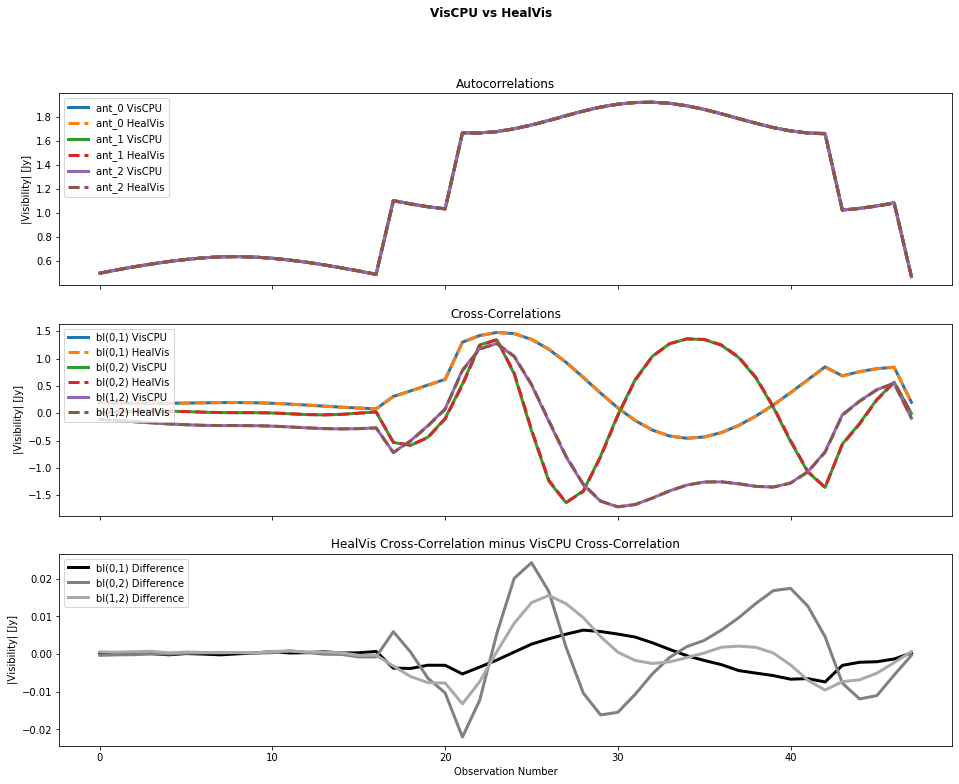

In [21]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### Example HERA Simulation

In [32]:
NTIMES = 48
ants = {}

with open("antenna_positions_37.txt") as fp:
    for line in enumerate(fp):
        num = line[0]
        enu = list(map(float, line[1].split()))
        ants.update({num : enu})

# antpos = pyuvsim.simsetup._parse_layout_csv("HERA_350.csv")

# e = antpos['e']
# n = antpos['n']
# u = antpos['u']

# for i in range(len(enu)):
#     ants.update({i : (e[i], n[i], u[i])})

uvdata = io.empty_uvdata(
                ants=ants,
                nfreq=5,
                integration_time=sday.to('s')/NTIMES,
                ntimes=NTIMES
               )

uvdata1 = io.empty_uvdata(
                ants=ants,
                nfreq=5,
                integration_time=sday.to('s')/NTIMES,
                ntimes=NTIMES
               )

In [33]:
# pygsm required
nbase = 4
nside = 2**nbase
npix = nside**2 * 12
freqs = np.unique(uvdata.freq_array)

# Construct a GSM and convert it from [K] to [Jy/Sr]
I_sky_Kelvin = gsm_shell(Nside=nside, freqs=freqs)
pix_area = 4 * np.pi / float(npix)
I_sky = I_sky_Kelvin / jy2Tsr(f=freqs, bm=pix_area)

# Native healvis format differs from VisibilitySimulators
I_sky = I_sky.T

In [34]:
viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_intensity=I_sky,
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_intensity=I_sky,
)

In [35]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.05min, Remain 0.040hour, MaxRSS 0.462748GB
Finished: 2, Elapsed 0.07min, Remain 0.028hour, MaxRSS 0.512336GB
Finished: 3, Elapsed 0.09min, Remain 0.023hour, MaxRSS 0.512348GB
Finished: 4, Elapsed 0.11min, Remain 0.021hour, MaxRSS 0.512348GB
Finished: 5, Elapsed 0.13min, Remain 0.019hour, MaxRSS 0.512348GB
Finished: 6, Elapsed 0.16min, Remain 0.018hour, MaxRSS 0.512348GB
Finished: 7, Elapsed 0.18min, Remain 0.017hour, MaxRSS 0.512348GB
Finished: 8, Elapsed 0.20min, Remain 0.016hour, MaxRSS 0.512348GB
Finished: 9, Elapsed 0.22min, Remain 0.016hour, MaxRSS 0.512348GB
Finished: 10, Elapsed 0.24min, Remain 0.015hour, MaxRSS 0.512348GB
Finished: 11, Elapsed 0.26min, Remain 0.015hour, MaxRSS 0.512348GB
Finished: 12, Elapsed 0.28min, Remain 0.014hour, MaxRSS 0.512348GB
Finished: 13, Elapsed 0.30min, Remain 0.014hour, MaxRSS 0.512348GB
Finished: 14, Elapsed 0.32min, Remain 0.013hour, MaxRSS 0.512348GB
Finished: 15, Elapsed 0.35min, Remain 0.013hour, MaxRSS 0.512348GB
Fini

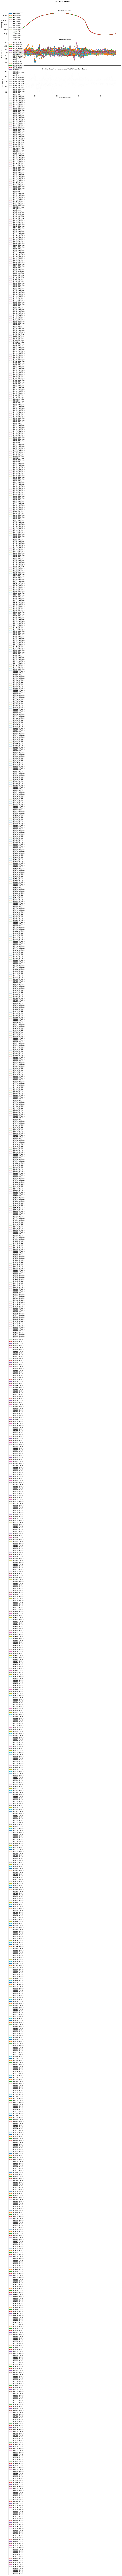

In [36]:
compare_blts(viscpu_sim, healvis_sim)

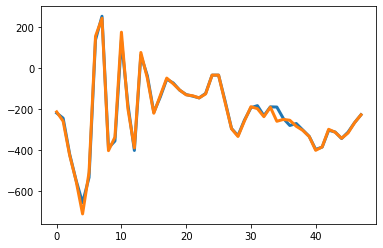

In [37]:
cross_ind = healvis_sim.uvdata.antpair2ind((3, 8))
cross_cor = healvis_sim.uvdata.data_array[cross_ind, 0, 0, 0]
plt.plot(cross_cor)

cross_ind = viscpu_sim.uvdata.antpair2ind((3, 8))
cross_cor = viscpu_sim.uvdata.data_array[cross_ind, 0, 0, 0]
plt.plot(cross_cor)